In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import Adam

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
training_data = pd.read_csv('/content/drive/My Drive/cnndata/cnntrain.csv')
testing_data = pd.read_csv('/content/drive/My Drive/cnndata/cnntest.csv')

In [10]:
training_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [12]:
y = training_data.iloc[:, 0:1].values

In [13]:
X = training_data.iloc[:, 1:].values

In [14]:
X = X/255.0
testing_data = testing_data.values/255.0

In [15]:
X = X.reshape(-1, 28, 28, 1)

In [16]:
testing_data = testing_data.reshape(-1, 28, 28, 1)

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), [0])], 
    remainder='passthrough'                         
)

y = ct.fit_transform(y).toarray()

In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

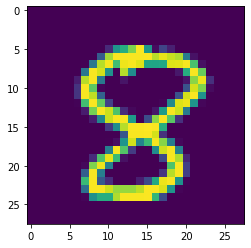

In [23]:
plt.imshow(X_train[1][:,:,0])
plt.show()

In [24]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
classifier.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(.1))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(.1))
classifier.add(Flatten())
classifier.add(Dense(units=300, activation='relu'))
classifier.add(Dropout(rate=0.1))
classifier.add(Dense(units=150, activation='relu'))
classifier.add(Dropout(rate=0.1))
classifier.add(Dense(units=10, activation='softmax'))

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.25, patience=2, min_lr=0.0001)

In [26]:
classifier.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the CNN on DATASET using the keras documentation

train_datagen = ImageDataGenerator(shear_range=0.2,
                                   zoom_range=0.2,
                                   height_shift_range=.1,
                                   rotation_range=10,
                                   width_shift_range=.1)

train_datagen.fit(X_train)

In [ ]:
classifier.fit_generator(
        train_datagen.flow(X_train,y_train, batch_size=40),
        steps_per_epoch=X_train.shape[0] // 40,
        epochs=40,
        validation_data=(X_test,y_test),callbacks=[reduce_lr])

In [31]:
# Prediction

submission = classifier.predict(testing_data)

# Maximum Probability Index

submission = np.argmax(submission, axis = 1)
submission = pd.Series(submission,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),submission],axis = 1)

submission.to_csv("/content/drive/My Drive/cnndata/submission.csv",index=False)